# This Fish Does Not Exist

> "Implementation of DCGAN from scratch using PyTorch framework on a custom Dataset"    


### From Kaggle to Colab

- Use the steps as devised in the [Blog](https://s-b-iqbal.github.io/Reflexione/pytorch/dataloaders/image%20manipulation/2021/06/11/Image-Loading.html)

### Libraries

In [15]:
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

import time
import glob
from pathlib import Path
torch.manual_seed(1)
np.random.seed(1)

from settings import *
from data import FishDataset
from utils import *
from dcgan import DCGAN
from training import train_gan
from plotting import plot_multiple_training_losses, generate_img
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

### Data Ingestion

In [2]:
data_path = Path.cwd()/'Fish_Dataset/Fish_Dataset'

# Path for all the files in a 'png' format.
image_path = list(data_path.glob('**/*.png')) 

# Separate Segmented from Non-Segmented Images
non_segmented_images = [img for img in image_path if 'GT' not in str(img)]
labels_non_segment = [img.parts[-3] for img in non_segmented_images]
segmented_images = [img for img in image_path if 'GT' in str(img)]
lables_segment = [img.parts[-3] for img in segmented_images]
classes = list(set(lables_segment))

# Convert String Labels to int
int_classes = {fish:i for i,fish in enumerate(classes)}
lables = [int_classes[lable] for lable in labels_non_segment]
image_data = pd.DataFrame({'Path': non_segmented_images,\
              'labels': lables})

### Data Pre-Processing

In [3]:
set_deterministic
set_all_seeds(RANDOM_SEED)

In [4]:
##########################
### Dataset
##########################
custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize([IMAGE_HEIGHT+5, IMAGE_WIDTH+5]),
    torchvision.transforms.CenterCrop([IMAGE_HEIGHT, IMAGE_WIDTH]),
    torchvision.transforms.RandomRotation(5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

data = FishDataset(images = image_data.Path, labels = image_data.labels,
                  transform= custom_transforms)

data_loader = DataLoader(data,batch_size=BATCH_SIZE,num_workers=WORKERS,shuffle= True)

In [5]:
# Checking the dataset
print('Training Set:\n')
for images, labels in data_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    break

Training Set:

Image batch dimensions: torch.Size([64, 3, 64, 64])
Image label dimensions: torch.Size([64])


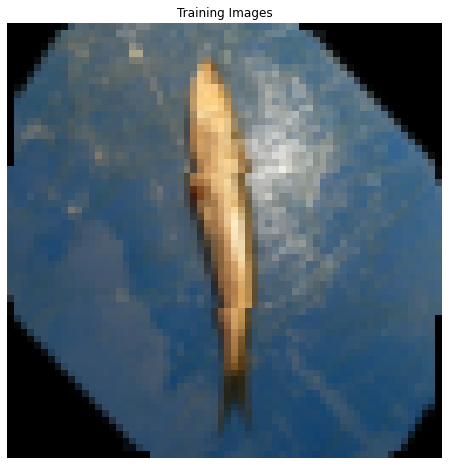

In [104]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[3:4], 
                                         padding=1, normalize=True),
                        (1, 2, 0)))

## Architecture Setup

In [7]:
class DCGAN(nn.Module):

    def __init__(self, latent_dim=100,
                 num_feat_maps_gen=64,
                 num_feat_maps_dis=64,
                     color_channels=3):
        super().__init__()

        self.generator = nn.Sequential(
            nn.ConvTranspose2d(latent_dim,num_feat_maps_gen*8,
                               kernel_size=4,stride=1,padding=0,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*8),
            nn.LeakyReLU(inplace=True),
            nn.Dropout2d(),

            nn.ConvTranspose2d(num_feat_maps_gen*8, num_feat_maps_gen*4,
                               kernel_size=4,stride=2,padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*4),
            nn.LeakyReLU(inplace=True),
            nn.Dropout2d(),
            
            nn.ConvTranspose2d(num_feat_maps_gen*4,num_feat_maps_gen*2,
                               kernel_size=4,stride=2,padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*2),
            nn.LeakyReLU(inplace=True),
            nn.Dropout2d(),

            nn.ConvTranspose2d(num_feat_maps_gen*2, num_feat_maps_gen,
                               kernel_size=4,stride=2,padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen),
            nn.LeakyReLU(inplace=True),
            nn.Dropout2d(),

            nn.ConvTranspose2d(num_feat_maps_gen, color_channels,
                               kernel_size=4,stride=2,padding=1,bias=False),
        nn.Tanh()

        )

        self.discriminator = nn.Sequential(
            nn.Conv2d(color_channels, num_feat_maps_dis,kernel_size=4,stride=2,padding=1),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(num_feat_maps_dis,num_feat_maps_dis*2 ,kernel_size=4,stride=2,padding=1, bias=False),
            nn.BatchNorm2d(num_feat_maps_dis*2),
            nn.LeakyReLU(inplace=True),
            
            nn.Conv2d(num_feat_maps_dis*2,num_feat_maps_dis*4 ,kernel_size=4,stride=2,padding=1, bias=False),
            nn.BatchNorm2d(num_feat_maps_dis*4),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(num_feat_maps_dis*4,num_feat_maps_dis*8 ,kernel_size=4,stride=2,padding=1, bias=False),
            nn.BatchNorm2d(num_feat_maps_dis*8),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(num_feat_maps_dis*8,1,kernel_size=4, stride=1, padding=0),
            nn.Flatten(),
        )

    def generator_forward(self,z):
        img = self.generator(z)
        return img
    def discriminator_forward(self,img):
        logits = model.discriminator(img) # NOTE: do not use self.discriminator(img)
        return logits

In [8]:
set_all_seeds(RANDOM_SEED)

model = DCGAN()
model.to(DEVICE)


optim_gen = torch.optim.Adam(model.generator.parameters(),
                             betas=(0.5, 0.999),
                             lr=GENERATOR_LEARNING_RATE)

optim_discr = torch.optim.Adam(model.discriminator.parameters(),
                               betas=(0.5, 0.999),
                               lr=DISCRIMINATOR_LEARNING_RATE)

printmd(f"__The Model Architecture :__ \n ")
print(model)

__The Model Architecture :__ 
 

DCGAN(
  (generator): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Dropout2d(p=0.5, inplace=False)
    (4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01, inplace=True)
    (7): Dropout2d(p=0.5, inplace=False)
    (8): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01, inplace=True)
    (11): Dropout2d(p=0.5, inplace=False)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(64, eps=1e-

### Training

In [18]:
log_dict = train_gan(num_epochs=NUM_EPOCHS, model=model, 
                        optimizer_gen=optim_gen,
                        optimizer_discr=optim_discr,
                        latent_dim=100,
                        device=DEVICE, 
                        train_loader=data_loader,
                        logging_interval=100,
                        save_model='fish_gan.pt')

### Observing Loss

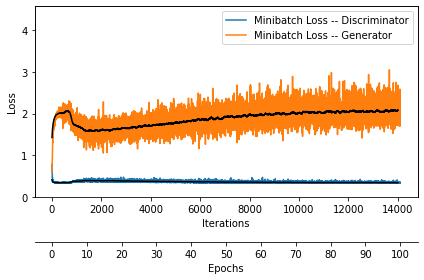

In [16]:
plot_multiple_training_losses(
    losses_list=(log_dict['train_discriminator_loss_per_batch'],
                 log_dict['train_generator_loss_per_batch']),
    num_epochs=NUM_EPOCHS, 
    custom_labels_list=(' -- Discriminator', ' -- Generator')
)

## Visualizing Results


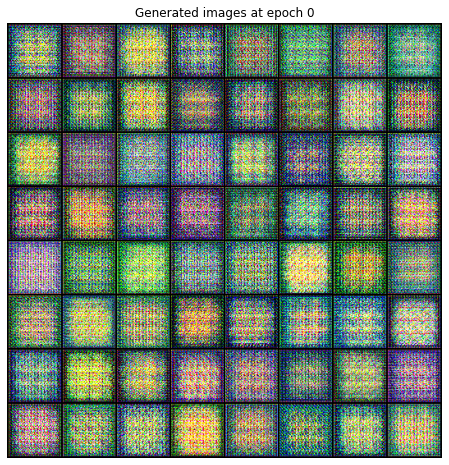

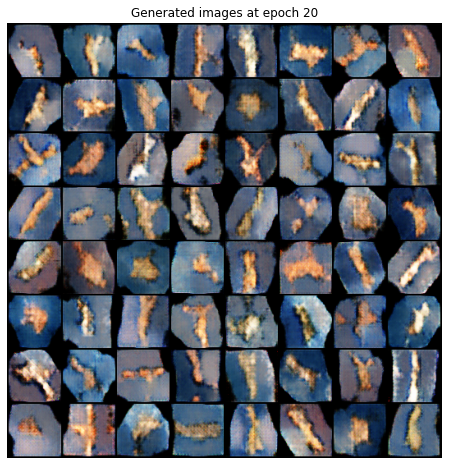

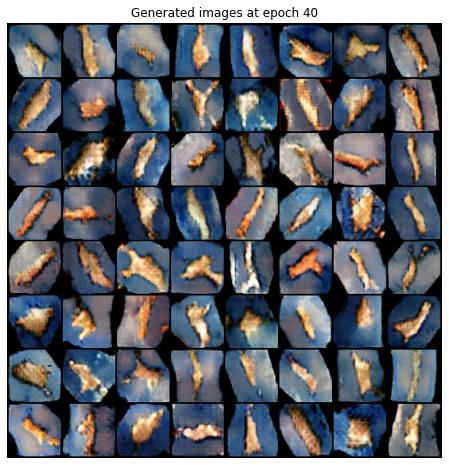

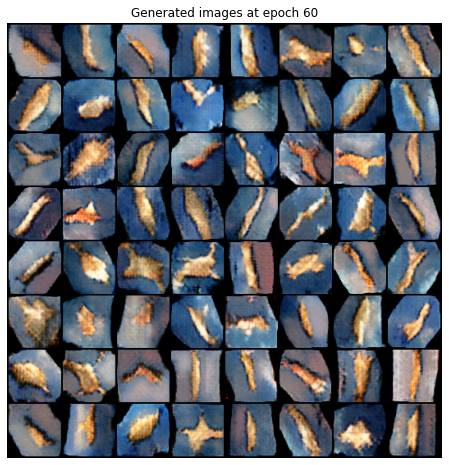

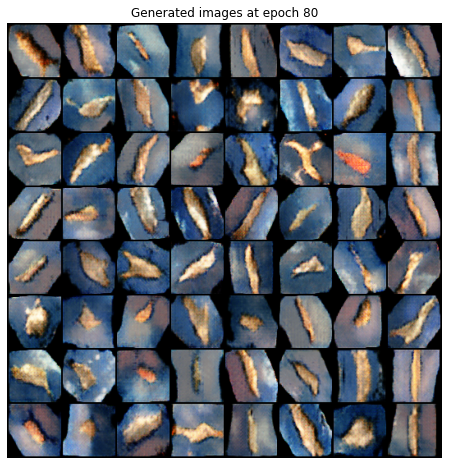

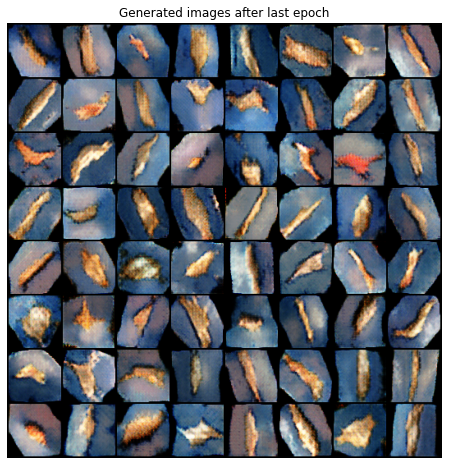

In [42]:
##########################
### VISUALIZATION
##########################

for i in range(0, NUM_EPOCHS, 20):
    
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.title(f'Generated images at epoch {i}')
    plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][i], (1, 2, 0)))
    plt.show()
    
    
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title(f'Generated images after last epoch')
plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][-1], (1, 2, 0)))
plt.show()

## Image Generation

- The most fun part....using the model to generate new images.

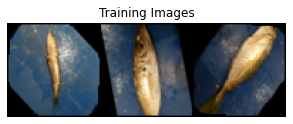

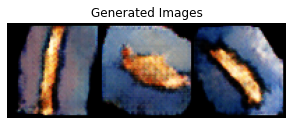

In [129]:
plt.figure(figsize=(5,5))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[3:6], 
                                         padding=1, normalize=True),
                        (1, 2, 0)))
plt.show()
### GAN Output
generate_img(model,3) # Generates 3 random images